In [1]:
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import re

# XGBoost

* **learning_rate:** tasa de aprendizaje
* **max_depth:** máxima profundidad de cada árbol
* **subsample:** porcentaje de muestras usadas para cada árbol (valor muy bajo, posible underfitting)
* **colsample_bytree:** porcentaje de features usadas para cada árbol (valores muy alto, posible overfitting)
* **n_estimators:** cantidad de árboles a construir.
* **objective:** función de error a utilizar (algunas: reg:squarederror para regresión, reg:logistic o binary:logistic para clasificación)

Parámetros de regularización:

* **gamma:** umbral para hacer split basado en la reducción de error de hacer el nuevo split.
* **alpha:** regularización para los pesos de las hojas. Un valor más alto genera una mayor regularización.
* **lambda:** similar alpha pero para la sintonia fina.

### Dataset del TP2
* Hacemos una transformacion basica solo para probar el XGBoost

In [2]:
train = pd.read_csv('../train.csv')

train['keyword'] = train['keyword'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)
train['location'] = train['location'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)
train['text'] = train['text'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)
train = train[['keyword', 'location', 'text', 'target']]

### Divimos el dataSet en Train y Test

In [3]:
X, y = train.iloc[:,:-1],train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

### Instanciamos XGBoost

In [4]:
xg_reg = xgb.XGBClassifier(eval_metric='auc',n_jobs=4,silent=False)

### Entrenamos

In [5]:
xg_reg.fit(X_train,y_train)

[19:11:51] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='auc',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, silent=False, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Predecimos

In [6]:
preds = xg_reg.predict(X_test)

### Calculamos el Error con 'accuracy' como medicion

In [7]:
preds = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 62.84%


In [8]:
dfAcc = pd.DataFrame({'transformation': [], 'accuracy': []})
dfAcc.loc[dfAcc.shape[0]] = ['Trans0', accuracy]

### XGBoost Transformacion1 - Agregando feature 'text_contains_keyword'

In [9]:
train = pd.read_csv('../train.csv')

#cantidad rows 7613
def is_in_text(keyword, text):
    is_in = 1
    arrKeyword = keyword.split("_")
    for key in arrKeyword:
        if not(key.upper() in text.upper() and key != ''):
            is_in = 0
            break
    
    return is_in


train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', '_') if (isinstance(x, str)) else '')
train['text_contains_keyword'] = train.apply(lambda x: is_in_text(x.keyword, x.text), axis=1)
train['keyword'] = train['keyword'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)
train['text'] = train['text'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)

train = train[['keyword', 'text_contains_keyword', 'text', 'target']]
train

,keyword,text_contains_keyword,text,target
0,0,0,69,1
1,0,0,38,1
2,0,0,133,1
3,0,0,65,1
4,0,0,88,1
...,...,...,...,...
7608,0,0,83,1
7609,0,0,125,1
7610,0,0,65,1
7611,0,0,137,1


In [10]:
X, y = train.iloc[:,:-1],train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',n_jobs=4, silent=False)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
preds = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[19:11:52] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 63.10%


Text(0.5, 1.0, 'Evolution Accuracy')

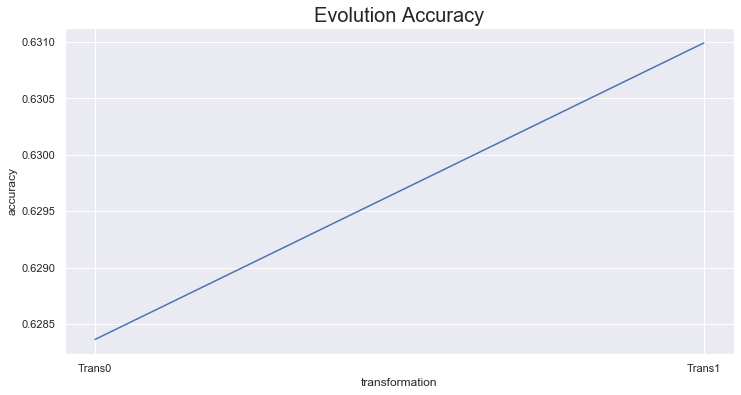

In [11]:
dfAcc.loc[dfAcc.shape[0]] = ['Trans1', accuracy]
plt.figure(figsize=(12, 6))
g = sns.lineplot(x="transformation", y="accuracy", data=dfAcc)
g.set_title("Evolution Accuracy", fontsize=20)

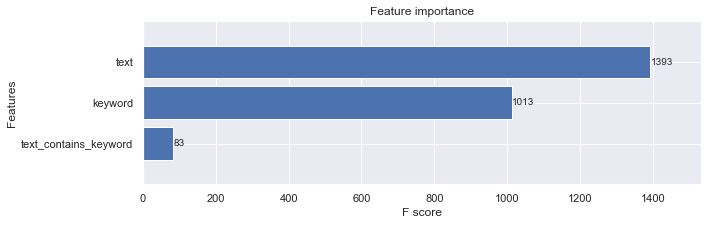

In [12]:
fig, ax = plt.subplots(figsize=(10,3))
xgb.plot_importance(xg_reg, max_num_features=50, height=0.8, ax=ax)

### XGBoost Transformacion2 - Agregando feature 'mean_keyword'
* Cantidad de veces que se repite la keyword / la cantidad total de tweets

In [13]:
train = pd.read_csv('../train.csv')

#cantidad rows 7613
def is_in_text(keyword, text):
    is_in = 1
    arrKeyword = keyword.split("_")
    for key in arrKeyword:
        if not(key.upper() in text.upper() and key != ''):
            is_in = 0
            break
    
    return is_in


train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', '_') if (isinstance(x, str)) else '')

keywords = train['keyword'].value_counts().to_frame().reset_index()
keywords.columns =['keyword', 'mean_keyword']
train = pd.merge(train, keywords, how='left', on='keyword')

train['mean_keyword'] = train['mean_keyword'].apply(lambda x: x/len(train))
train['text_contains_keyword'] = train.apply(lambda x: is_in_text(x.keyword, x.text), axis=1)
train['keyword'] = train['keyword'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)
train['text'] = train['text'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)

train = train[['keyword', 'text_contains_keyword', 'mean_keyword', 'text', 'target']]
train

,keyword,text_contains_keyword,mean_keyword,text,target
0,0,0,0.008013,69,1
1,0,0,0.008013,38,1
2,0,0,0.008013,133,1
3,0,0,0.008013,65,1
4,0,0,0.008013,88,1
...,...,...,...,...,...
7608,0,0,0.008013,83,1
7609,0,0,0.008013,125,1
7610,0,0,0.008013,65,1
7611,0,0,0.008013,137,1


In [14]:
X, y = train.iloc[:,:-1],train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',n_jobs=4, silent=False)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
preds = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[19:11:55] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 66.12%


Text(0.5, 1.0, 'Evolution Accuracy')

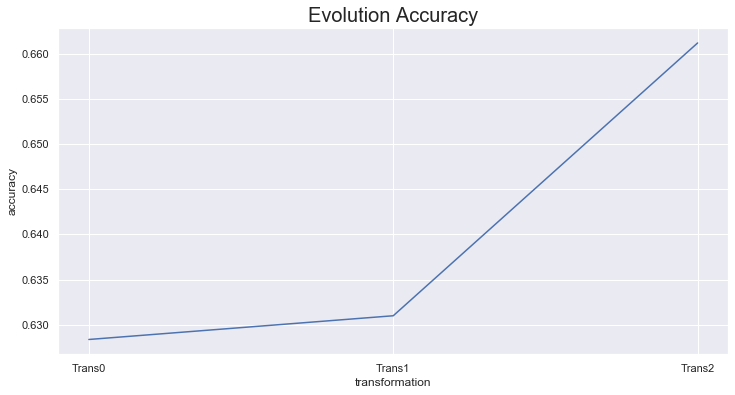

In [15]:
dfAcc.loc[dfAcc.shape[0]] = ['Trans2', accuracy]
plt.figure(figsize=(12, 6))
g = sns.lineplot(x="transformation", y="accuracy", data=dfAcc)
g.set_title("Evolution Accuracy", fontsize=20)

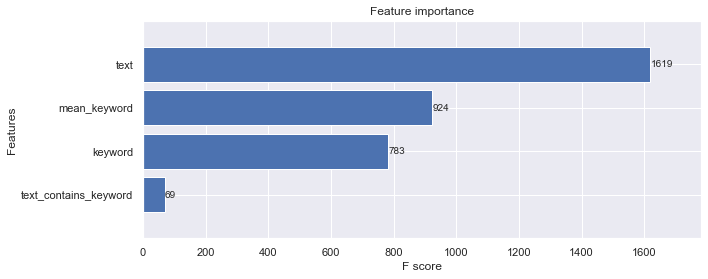

In [16]:
fig, ax = plt.subplots(figsize=(10,4))
xgb.plot_importance(xg_reg, max_num_features=50, height=0.8, ax=ax)

### XGBoost Transformacion3 - Agregando feature 'mean_text_contains_keyword'
* Cantidad de veces que si aparece la keyword en el texto/ la cantidad total que aparece la keyword

In [17]:
train = pd.read_csv('../train.csv')

#cantidad rows 7613
def is_in_text(keyword, text):
    is_in = 1
    arrKeyword = keyword.split("_")
    for key in arrKeyword:
        if not(key.upper() in text.upper() and key != ''):
            is_in = 0
            break
    
    return is_in


train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', '_') if (isinstance(x, str)) else '')

keywords = train['keyword'].value_counts().to_frame().reset_index()
keywords.columns =['keyword', 'mean_keyword']
train = pd.merge(train, keywords, how='left', on='keyword')

train['mean_keyword'] = train['mean_keyword'].apply(lambda x: x/len(train))
train['text_contains_keyword'] = train.apply(lambda x: is_in_text(x.keyword, x.text), axis=1)

groupbyKeyword = train.groupby(['keyword'])['text_contains_keyword']
text_contains_keyword_sum = groupbyKeyword.sum().reset_index(name='value')
text_contains_keyword_count = groupbyKeyword.count().reset_index(name='value')
mean_text_contains_keyword = pd.DataFrame({'keyword': text_contains_keyword_sum['keyword'], 'mean_text_contains_keyword': text_contains_keyword_sum['value']/text_contains_keyword_count['value']})
train = pd.merge(train, mean_text_contains_keyword, how='left', on='keyword')

train['keyword'] = train['keyword'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)
train['text'] = train['text'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)

train = train[['keyword', 'text_contains_keyword', 'mean_keyword', 'mean_text_contains_keyword', 'text', 'target']]
train

,keyword,text_contains_keyword,mean_keyword,mean_text_contains_keyword,text,target
0,0,0,0.008013,0.0,69,1
1,0,0,0.008013,0.0,38,1
2,0,0,0.008013,0.0,133,1
3,0,0,0.008013,0.0,65,1
4,0,0,0.008013,0.0,88,1
...,...,...,...,...,...,...
7608,0,0,0.008013,0.0,83,1
7609,0,0,0.008013,0.0,125,1
7610,0,0,0.008013,0.0,65,1
7611,0,0,0.008013,0.0,137,1


In [18]:
X, y = train.iloc[:,:-1],train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',n_jobs=4, silent=False)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
preds = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[19:11:59] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 71.04%


Text(0.5, 1.0, 'Evolution Accuracy')

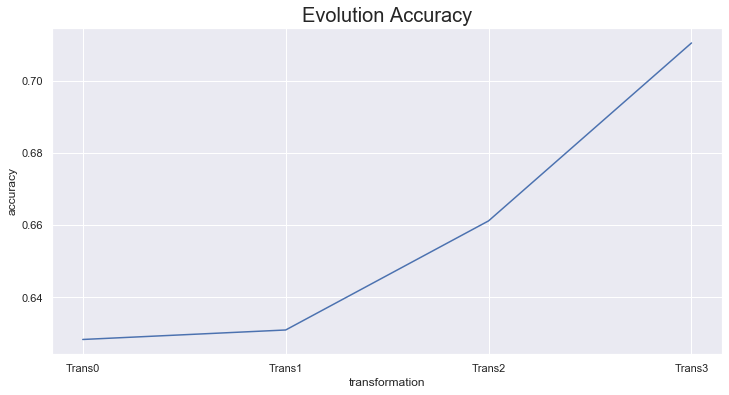

In [19]:
dfAcc.loc[dfAcc.shape[0]] = ['Trans3', accuracy]
plt.figure(figsize=(12, 6))
g = sns.lineplot(x="transformation", y="accuracy", data=dfAcc)
g.set_title("Evolution Accuracy", fontsize=20)

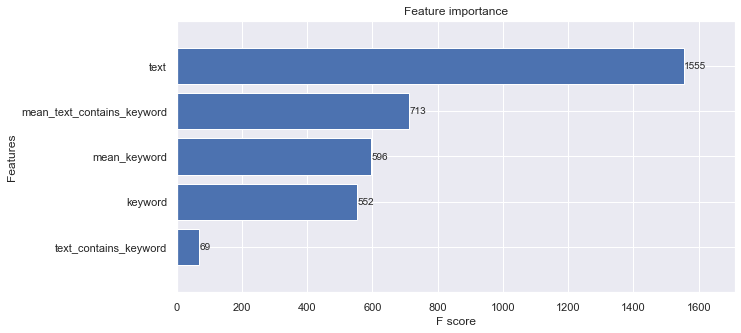

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
xgb.plot_importance(xg_reg, max_num_features=50, height=0.8, ax=ax)

### XGBoost Transformacion4 - Agregando feature 'word_count'
* Cantidad de palabras que aparecen en el tweet

In [21]:
train = pd.read_csv('../train.csv')

#cantidad rows 7613
def is_in_text(keyword, text):
    is_in = 1
    arrKeyword = keyword.split("_")
    for key in arrKeyword:
        if not(key.upper() in text.upper() and key != ''):
            is_in = 0
            break
    
    return is_in


train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', '_') if (isinstance(x, str)) else '')

keywords = train['keyword'].value_counts().to_frame().reset_index()
keywords.columns =['keyword', 'mean_keyword']
train = pd.merge(train, keywords, how='left', on='keyword')

train['mean_keyword'] = train['mean_keyword'].apply(lambda x: x/len(train))
train['text_contains_keyword'] = train.apply(lambda x: is_in_text(x.keyword, x.text), axis=1)

groupbyKeyword = train.groupby(['keyword'])['text_contains_keyword']
text_contains_keyword_sum = groupbyKeyword.sum().reset_index(name='value')
text_contains_keyword_count = groupbyKeyword.count().reset_index(name='value')
mean_text_contains_keyword = pd.DataFrame({'keyword': text_contains_keyword_sum['keyword'], 'mean_text_contains_keyword': text_contains_keyword_sum['value']/text_contains_keyword_count['value']})
train = pd.merge(train, mean_text_contains_keyword, how='left', on='keyword')

train['keyword'] = train['keyword'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)
train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train['text'] = train['text'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)

train = train[['keyword', 'text_contains_keyword', 'mean_keyword', 'mean_text_contains_keyword', 'text', 'word_count', 'target']]
train

,keyword,text_contains_keyword,mean_keyword,mean_text_contains_keyword,text,word_count,target
0,0,0,0.008013,0.0,69,13,1
1,0,0,0.008013,0.0,38,7,1
2,0,0,0.008013,0.0,133,22,1
3,0,0,0.008013,0.0,65,8,1
4,0,0,0.008013,0.0,88,16,1
...,...,...,...,...,...,...,...
7608,0,0,0.008013,0.0,83,11,1
7609,0,0,0.008013,0.0,125,20,1
7610,0,0,0.008013,0.0,65,8,1
7611,0,0,0.008013,0.0,137,19,1


In [22]:
X, y = train.iloc[:,:-1],train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',n_jobs=4, silent=False)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
preds = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[19:12:02] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 72.82%


Text(0.5, 1.0, 'Evolution Accuracy')

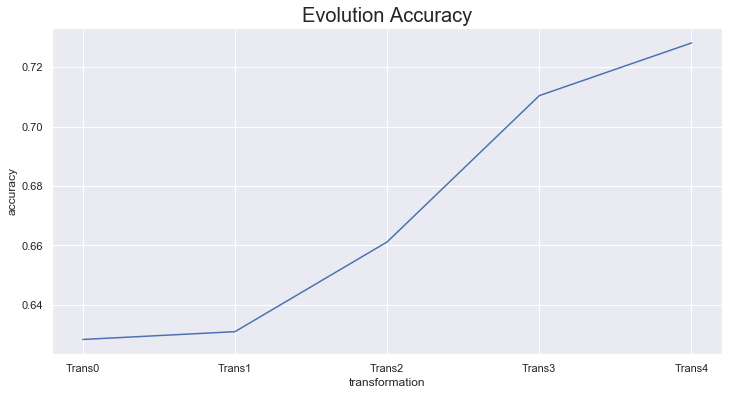

In [23]:
dfAcc.loc[dfAcc.shape[0]] = ['Trans4', accuracy]
plt.figure(figsize=(12, 6))
g = sns.lineplot(x="transformation", y="accuracy", data=dfAcc)
g.set_title("Evolution Accuracy", fontsize=20)

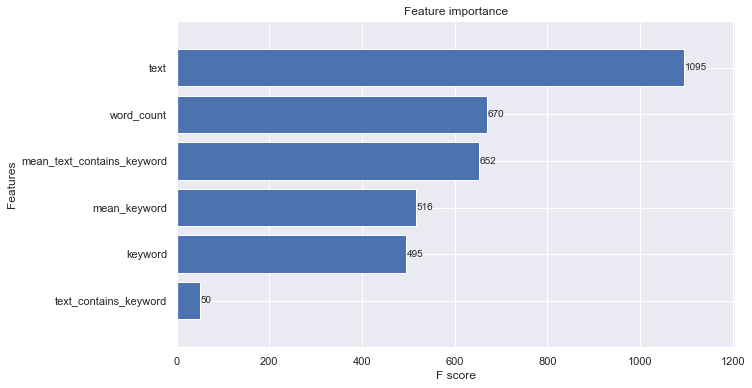

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
xgb.plot_importance(xg_reg, max_num_features=50, height=0.8, ax=ax)

### XGBoost Transformacion5 - Agregando features 'word_mean_len', 'upper_count', 'white_count', 'url_count', 'hashtag_count', 'mention_count'
* Todas estas features se basan en el texto del tweet

In [25]:
train = pd.read_csv('../train.csv')

#cantidad rows 7613
def is_in_text(keyword, text):
    is_in = 1
    arrKeyword = keyword.split("_")
    for key in arrKeyword:
        if not(key.upper() in text.upper() and key != ''):
            is_in = 0
            break
    
    return is_in


train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', '_') if (isinstance(x, str)) else '')

keywords = train['keyword'].value_counts().to_frame().reset_index()
keywords.columns =['keyword', 'mean_keyword']
train = pd.merge(train, keywords, how='left', on='keyword')

train['mean_keyword'] = train['mean_keyword'].apply(lambda x: x/len(train))
train['text_contains_keyword'] = train.apply(lambda x: is_in_text(x.keyword, x.text), axis=1)

groupbyKeyword = train.groupby(['keyword'])['text_contains_keyword']
text_contains_keyword_sum = groupbyKeyword.sum().reset_index(name='value')
text_contains_keyword_count = groupbyKeyword.count().reset_index(name='value')
mean_text_contains_keyword = pd.DataFrame({'keyword': text_contains_keyword_sum['keyword'], 'mean_text_contains_keyword': text_contains_keyword_sum['value']/text_contains_keyword_count['value']})
train = pd.merge(train, mean_text_contains_keyword, how='left', on='keyword')

train['keyword'] = train['keyword'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)

train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train['word_mean_len'] = train['text'].apply(lambda x: np.mean([len(c) for c in str(x).split()])) 
train['upper_count'] = train['text'].apply(lambda x: len(re.findall("[ A-Z ]",x)))
train['white_count'] = train['text'].apply(lambda x: len(re.findall(r'\s+',x)))
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
train['text'] = train['text'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)

train = train[['keyword', 'text_contains_keyword', 'mean_keyword', 'mean_text_contains_keyword', 'text', \
               'word_count', 'word_mean_len', 'upper_count', 'white_count', 'url_count', 'hashtag_count', 'mention_count', 'target']]
train

,keyword,text_contains_keyword,mean_keyword,mean_text_contains_keyword,text,word_count,word_mean_len,upper_count,white_count,url_count,hashtag_count,mention_count,target
0,0,0,0.008013,0.0,69,13,4.384615,22,12,0,1,0,1
1,0,0,0.008013,0.0,38,7,4.571429,11,6,0,0,0,1
2,0,0,0.008013,0.0,133,22,5.090909,23,21,0,0,0,1
3,0,0,0.008013,0.0,65,8,7.125000,9,8,0,1,0,1
4,0,0,0.008013,0.0,88,16,4.500000,19,16,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,0,0,0.008013,0.0,83,11,6.636364,17,10,1,0,0,1
7609,0,0,0.008013,0.0,125,20,5.300000,25,19,0,0,2,1
7610,0,0,0.008013,0.0,65,8,7.250000,17,7,1,0,0,1
7611,0,0,0.008013,0.0,137,19,6.263158,22,18,0,0,0,1


In [26]:
X, y = train.iloc[:,:-1],train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',n_jobs=4, silent=False)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
preds = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

[19:12:06] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


Accuracy: 73.34%


Text(0.5, 1.0, 'Evolution Accuracy')

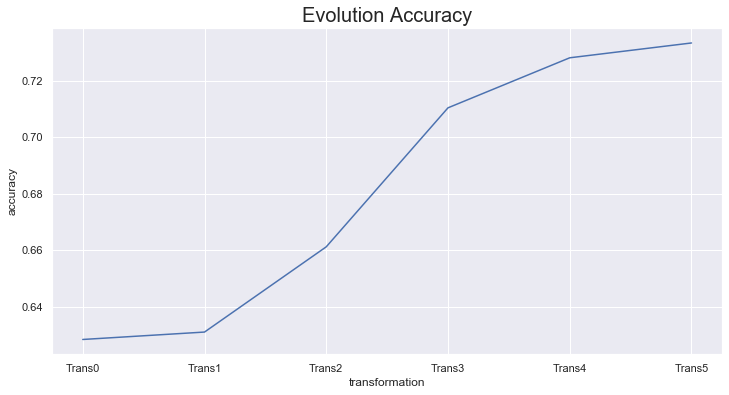

In [27]:
dfAcc.loc[dfAcc.shape[0]] = ['Trans5', accuracy]
plt.figure(figsize=(12, 6))
g = sns.lineplot(x="transformation", y="accuracy", data=dfAcc)
g.set_title("Evolution Accuracy", fontsize=20)

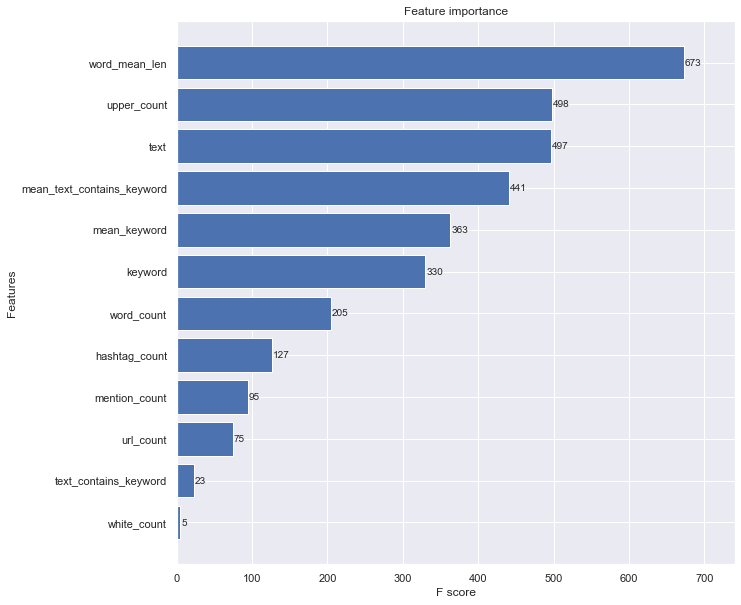

In [28]:
fig, ax = plt.subplots(figsize=(10,10))
xgb.plot_importance(xg_reg, max_num_features=50, height=0.8, ax=ax)

### XGBoost Transformacion6 - Agregando feature de 100 dimensiones generado por GLoVe - Embedding
* Cargamos una imagen pre entrenada por GloVe de 100 dimensiones, el archivo tiene como nombre 'embedd_train.csv'

In [29]:
import pickle

pickle_in = open("../embedd_train.csv","rb")
embedd_train = pickle.load(pickle_in)
embedd_train = pd.DataFrame(embedd_train)
embedd_train

train = pd.read_csv('../train.csv')

#cantidad rows 7613
def is_in_text(keyword, text):
    is_in = 1
    arrKeyword = keyword.split("_")
    for key in arrKeyword:
        if not(key.upper() in text.upper() and key != ''):
            is_in = 0
            break
    
    return is_in


train['keyword'] = train['keyword'].apply(lambda x: x.replace('%20', '_') if (isinstance(x, str)) else '')

keywords = train['keyword'].value_counts().to_frame().reset_index()
keywords.columns =['keyword', 'mean_keyword']
train = pd.merge(train, keywords, how='left', on='keyword')

train['mean_keyword'] = train['mean_keyword'].apply(lambda x: x/len(train))
train['text_contains_keyword'] = train.apply(lambda x: is_in_text(x.keyword, x.text), axis=1)

groupbyKeyword = train.groupby(['keyword'])['text_contains_keyword']
text_contains_keyword_sum = groupbyKeyword.sum().reset_index(name='value')
text_contains_keyword_count = groupbyKeyword.count().reset_index(name='value')
mean_text_contains_keyword = pd.DataFrame({'keyword': text_contains_keyword_sum['keyword'], 'mean_text_contains_keyword': text_contains_keyword_sum['value']/text_contains_keyword_count['value']})
train = pd.merge(train, mean_text_contains_keyword, how='left', on='keyword')

train['keyword'] = train['keyword'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)

train['word_count'] = train['text'].apply(lambda x: len(str(x).split()))
train['word_mean_len'] = train['text'].apply(lambda x: np.mean([len(c) for c in str(x).split()])) 
train['upper_count'] = train['text'].apply(lambda x: len(re.findall("[ A-Z ]",x)))
train['white_count'] = train['text'].apply(lambda x: len(re.findall(r'\s+',x)))
train['url_count'] = train['text'].apply(lambda x: len([w for w in str(x).lower().split() if 'http' in w or 'https' in w]))
train['hashtag_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '#']))
train['mention_count'] = train['text'].apply(lambda x: len([c for c in str(x) if c == '@']))
train['text'] = train['text'].transform(lambda x: len(x) if (isinstance(x, str)) else 0)

train = train[[ 'keyword', 'text_contains_keyword', 'mean_keyword', 'mean_text_contains_keyword', 'text', \
               'word_count', 'word_mean_len', 'upper_count', 'white_count', 'url_count', 'hashtag_count', 'mention_count', 'target']]

train = pd.concat([embedd_train, train],axis=1)
train

,0,1,2,3,4,5,6,7,8,9,...,mean_text_contains_keyword,text,word_count,word_mean_len,upper_count,white_count,url_count,hashtag_count,mention_count,target
0,5473,718,154,66,1666,3595,13,0,0,0,...,0.0,69,13,4.384615,22,12,0,1,0,1
1,83,2,119,744,7954,7955,1118,0,0,0,...,0.0,38,7,4.571429,11,6,0,0,0,1
2,1453,1360,1955,615,7956,1667,172,1955,615,1555,...,0.0,133,22,5.090909,23,21,0,0,0,1
3,7,4305,1241,172,1555,30,0,0,0,0,...,0.0,65,8,7.125000,9,8,0,1,0,1
4,20,1361,195,5474,1803,188,1241,7957,112,0,...,0.0,88,16,4.500000,19,16,0,2,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7608,36,709,1412,962,285,82,556,129,0,0,...,0.0,83,11,6.636364,17,10,1,0,0,1
7609,7658,7659,7660,646,110,34,30,70,109,371,...,0.0,125,20,5.300000,25,19,0,0,2,1
7610,740,558,408,1441,0,0,0,0,0,0,...,0.0,65,8,7.250000,17,7,1,0,0,1
7611,14,1106,424,2221,343,53,169,4688,424,2221,...,0.0,137,19,6.263158,22,18,0,0,0,1


In [30]:
X, y = train.iloc[:,:-1],train.iloc[:,-1]
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.2, random_state=123)

xg_reg = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc',n_jobs=4, colsample_bytree = 0.3, learning_rate = 0.3, max_depth = 9, alpha = 10, n_estimators = 500)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)
preds = [round(value) for value in preds]
# evaluate predictions
accuracy = accuracy_score(y_test, preds)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.46%


Text(0.5, 1.0, 'Evolution Accuracy')

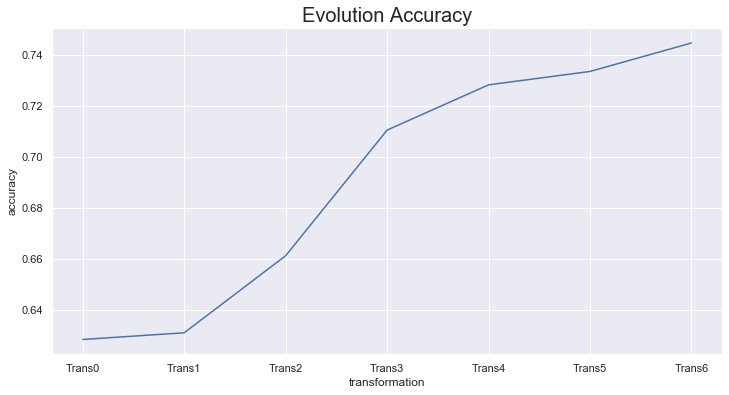

In [31]:
dfAcc.loc[dfAcc.shape[0]] = ['Trans6', accuracy]
plt.figure(figsize=(12, 6))
g = sns.lineplot(x="transformation", y="accuracy", markers=True, dashes=False, data=dfAcc)
g.set_title("Evolution Accuracy", fontsize=20)

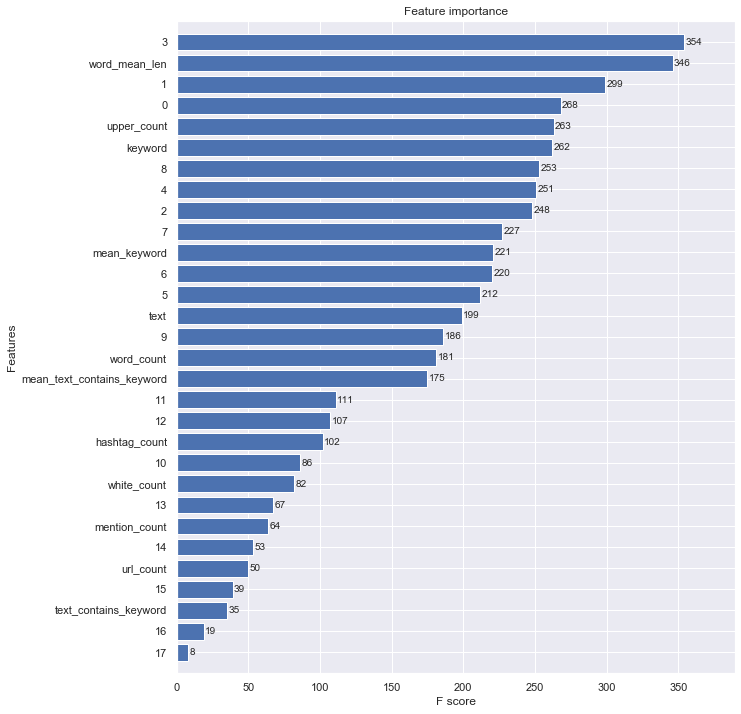

In [32]:
fig, ax = plt.subplots(figsize=(10,12))
xgb.plot_importance(xg_reg, max_num_features=50, height=0.8, ax=ax)

In [ ]:
#from tqdm import tqdm
#from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from nltk import word_tokenize
#from nltk.corpus import stopwords